In [1]:
!pip install adversarial-robustness-toolbox

In [2]:
import art

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Flatten, InputLayer, Reshape

from art.estimators.classification import KerasClassifier

#tf.compat.v1.disable_eager_execution()

## Prepare the dataset and the model architecture.

In [4]:
import art
from art.utils import load_mnist

# Load the dataset, and split the test data into test and steal datasets.
(x_train, y_train), (x_test0, y_test0), _, _ = load_mnist()
len_steal = 5000
indices = np.random.permutation(len(x_test0))
x_steal = x_test0[indices[:len_steal]]
y_steal = y_test0[indices[:len_steal]]
x_test = x_test0[indices[len_steal:]]
y_test = y_test0[indices[len_steal:]]

im_shape = x_train[0].shape
def get_model(num_classes=10, c1=32, c2=64, d1=128):
    model = Sequential()
    model.add(Conv2D(c1, kernel_size=(3, 3), activation='relu', input_shape=im_shape))
    model.add(Conv2D(c2, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(d1, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer="sgd",
                          metrics=['accuracy'])
    return model

## Train the original model.

In [5]:
num_epochs = 5
model = get_model(num_classes=10, c1=32, c2=64, d1=128)
print("Original model training:")
model.fit(x_train, y_train, batch_size=100, epochs=num_epochs)
print("Original model evaluation:")
print(model.evaluate(x_test, y_test))
classifier_original = KerasClassifier(model, clip_values=(0, 1), use_logits=False)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Original model training:
Epoch 1/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.6020 - loss: 1.4058
Epoch 2/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9187 - loss: 0.2717
Epoch 3/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9422 - loss: 0.1920
Epoch 4/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9542 - loss: 0.1539
Epoch 5/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9589 - loss: 0.1343
Original model evaluation:
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9450 - loss: 0.1706
[0.14969010651111603, 0.9516000151634216]


In [6]:
model

<Sequential name=sequential, built=True>

## Save the Model:

In [7]:
# save model and its architecture
model.save('/content/drive/MyDrive/AI SECURITY/AI Red Teaming/CODE/Model/target_tf_keras_minst_model_steal.h5')

## Load the Trained Model -> User Input:

In [8]:
model = tf.keras.models.load_model('/content/drive/MyDrive/AI SECURITY/AI Red Teaming/CODE/Model/target_tf_keras_minst_model_steal.h5')

## Attack:

In [9]:
# Stealing from the unprotected classifier.
from art.attacks import ExtractionAttack
from art.attacks.extraction import CopycatCNN, KnockoffNets

attack_catalogue = {"Probabilistic CopycatCNN": CopycatCNN(classifier=classifier_original,
                                                batch_size_fit=64,
                                                batch_size_query=64,
                                                nb_epochs=num_epochs,
                                                nb_stolen=len_steal,
                                                use_probability=True),
                      "Argmax CopycatCNN": CopycatCNN(classifier=classifier_original,
                                                batch_size_fit=64,
                                                batch_size_query=64,
                                                nb_epochs=num_epochs,
                                                nb_stolen=len_steal,
                                                use_probability=False),
                      "Probabilistic KnockoffNets": KnockoffNets(classifier=classifier_original,
                                                batch_size_fit=64,
                                                batch_size_query=64,
                                                nb_epochs=num_epochs,
                                                nb_stolen=len_steal,
                                                use_probability=True),
                      "Argmax KnockoffNets": KnockoffNets(classifier=classifier_original,
                                                batch_size_fit=64,
                                                batch_size_query=64,
                                                nb_epochs=num_epochs,
                                                nb_stolen=len_steal,
                                                use_probability=False),
                     }

results = []
for len_steal in [250, 500, 1000, 2000, 4000, 5000]:
      indices = np.random.permutation(len(x_test0))
      x_steal = x_test0[indices[:len_steal]]
      y_steal = y_test0[indices[:len_steal]]
      x_test = x_test0[indices[len_steal:]]
      y_test = y_test0[indices[len_steal:]]

      for name, attack in attack_catalogue.items():
          model_stolen = get_model(num_classes=10, c1=32, c2=64, d1=128)
          classifier_stolen = KerasClassifier(model_stolen, clip_values=(0, 1), use_logits=True)
          classifier_stolen = attack.extract(x_steal, y_steal, thieved_classifier=classifier_stolen)
          acc = classifier_stolen._model.evaluate(x_test, y_test)[1]
          print(name, ":", acc)
          results.append((name, len_steal, acc))

305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3656 - loss: 2.2504


Probabilistic CopycatCNN : 0.3669743537902832
305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1927 - loss: 2.2594


Argmax CopycatCNN : 0.186153843998909
305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3395 - loss: 2.2411


Probabilistic KnockoffNets : 0.3409230709075928
305/305 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.2718 - loss: 2.2414


Argmax KnockoffNets : 0.26902565360069275
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3874 - loss: 2.0681


Probabilistic CopycatCNN : 0.386947363615036
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2147 - loss: 2.1761


Argmax CopycatCNN : 0.21747368574142456
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3429 - loss: 2.2470


Probabilistic KnockoffNets : 0.33989474177360535
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2361 - loss: 2.2291


Argmax KnockoffNets : 0.24189473688602448
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7151 - loss: 1.2973


Probabilistic CopycatCNN : 0.7214444279670715
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7297 - loss: 1.5987


Argmax CopycatCNN : 0.7307778000831604
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7374 - loss: 1.4444


Probabilistic KnockoffNets : 0.74144446849823
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7287 - loss: 1.2461


Argmax KnockoffNets : 0.7350000143051147
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8630 - loss: 0.4608


Probabilistic CopycatCNN : 0.8637499809265137
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7891 - loss: 0.6421
Argmax CopycatCNN : 0.7841249704360962


250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7550 - loss: 0.7313
Probabilistic KnockoffNets : 0.7557500004768372


250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8355 - loss: 0.5867


Argmax KnockoffNets : 0.8364999890327454
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9003 - loss: 0.3338


Probabilistic CopycatCNN : 0.8963333368301392
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8889 - loss: 0.3602


Argmax CopycatCNN : 0.8883333206176758
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8802 - loss: 0.3942


Probabilistic KnockoffNets : 0.8755000233650208
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8852 - loss: 0.3709


Argmax KnockoffNets : 0.8818333148956299
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7748 - loss: 0.7315


Probabilistic CopycatCNN : 0.7738000154495239
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7050 - loss: 0.8962
Argmax CopycatCNN : 0.7044000029563904


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7534 - loss: 0.6777


Probabilistic KnockoffNets : 0.7504000067710876
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6891 - loss: 1.1183
Argmax KnockoffNets : 0.6855999827384949


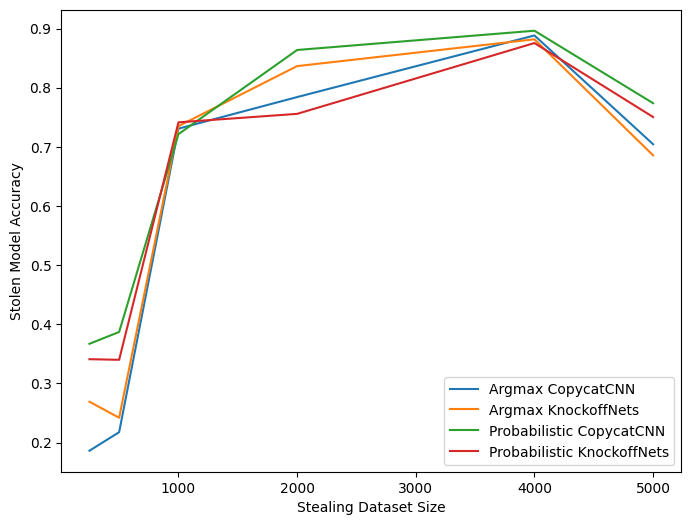

In [10]:
import pandas as pd
df = pd.DataFrame(results, columns=('Method Name', 'Stealing Dataset Size', 'Accuracy'))
fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlabel("Stealing Dataset Size")
ax.set_ylabel("Stolen Model Accuracy")
for name, group in df.groupby("Method Name"):
    group.plot(1, 2, ax=ax, label=name)
plt.show()

In [11]:
# Prepare the defense layer.
from art.defences.postprocessor import ReverseSigmoid
postprocessor = ReverseSigmoid(beta=1.0, gamma=0.2)
classifier_protected = KerasClassifier(model, clip_values=(0, 1), use_logits=False, postprocessing_defences=postprocessor)

# Below is used by `FunctionallyEquivalentExtraction`.
model_flat = Sequential([InputLayer([784]), Reshape([28, 28, 1]), model])
model_flat.compile('sgd', 'categorical_crossentropy', ['accuracy'])
classifier_flat_protected = KerasClassifier(model_flat, clip_values=(0, 1), use_logits=False, postprocessing_defences=postprocessor)

In [12]:
# Stealing from the protected classifier.

attack_catalogue = {
                    "Probabilistic CopycatCNN (vs. Protected)": CopycatCNN(classifier=classifier_protected,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=True),
                    "Argmax CopycatCNN (vs. Protected)": CopycatCNN(classifier=classifier_protected,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=False),
                    "Probabilistic KnockoffNets (vs. Protected)": KnockoffNets(classifier=classifier_protected,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=True),
                    "Argmax KnockoffNets (vs. Protected)": KnockoffNets(classifier=classifier_protected,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=False),
#                     "FunctionallyEquivalentExtraction": FunctionallyEquivalentExtraction(classifier=classifier_flat_protected,
#                                               num_neurons=128),  # This one takes too long time for this dataset/model.
                    }

results_protected = []
for len_steal in [250, 500, 1000, 2000, 4000, 5000]:
    indices = np.random.permutation(len(x_test0))
    x_steal = x_test0[indices[:len_steal]]
    y_steal = y_test0[indices[:len_steal]]
    x_test = x_test0[indices[len_steal:]]
    y_test = y_test0[indices[len_steal:]]

    for name, attack in attack_catalogue.items():
        model_stolen = get_model(num_classes=10, c1=32, c2=64, d1=128)
        classifier_stolen = KerasClassifier(model_stolen, clip_values=(0, 1), use_logits=False)
        if name=="FunctionallyEquivalentExtraction":
            classifier_stolen = attack.extract(np.reshape(x_steal, [len(x_steal), -1]), y_steal, thieved_classifier=classifier_stolen)
        else:
            classifier_stolen = attack.extract(x_steal, y_steal, thieved_classifier=classifier_stolen)

        acc = classifier_stolen._model.evaluate(x_test, y_test)[1]
        print(name, ":", acc)
        results_protected.append((name, len_steal, acc))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.0519 - loss: 2.3077


Probabilistic CopycatCNN (vs. Protected) : 0.054153844714164734
305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1153 - loss: 2.2593


Argmax CopycatCNN (vs. Protected) : 0.1133333370089531
305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0689 - loss: 2.3022


Probabilistic KnockoffNets (vs. Protected) : 0.07056410610675812
305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3543 - loss: 2.2548


Argmax KnockoffNets (vs. Protected) : 0.34933334589004517
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.0853 - loss: 2.2967


Probabilistic CopycatCNN (vs. Protected) : 0.0860000029206276
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4868 - loss: 2.0844


Argmax CopycatCNN (vs. Protected) : 0.4866315722465515
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0847 - loss: 2.3075


Probabilistic KnockoffNets (vs. Protected) : 0.08210526406764984
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4451 - loss: 2.1371


Argmax KnockoffNets (vs. Protected) : 0.44252631068229675
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.0794 - loss: 2.2999


Probabilistic CopycatCNN (vs. Protected) : 0.0793333351612091
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6460 - loss: 1.7012


Argmax CopycatCNN (vs. Protected) : 0.6421111226081848
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1542 - loss: 2.3051


Probabilistic KnockoffNets (vs. Protected) : 0.15477778017520905
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6699 - loss: 1.5897


Argmax KnockoffNets (vs. Protected) : 0.6654444336891174
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1508 - loss: 2.2926
Probabilistic CopycatCNN (vs. Protected) : 0.14875000715255737


250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8214 - loss: 0.5478


Argmax CopycatCNN (vs. Protected) : 0.8264999985694885
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1868 - loss: 2.2875
Probabilistic KnockoffNets (vs. Protected) : 0.18962499499320984


250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8514 - loss: 0.5150
Argmax KnockoffNets (vs. Protected) : 0.8576250076293945


188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3303 - loss: 2.2544


Probabilistic CopycatCNN (vs. Protected) : 0.33133333921432495
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8705 - loss: 0.4089


Argmax CopycatCNN (vs. Protected) : 0.8738333582878113
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3369 - loss: 2.2581


Probabilistic KnockoffNets (vs. Protected) : 0.3348333239555359
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8687 - loss: 0.4220


Argmax KnockoffNets (vs. Protected) : 0.8726666569709778
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3350 - loss: 2.2654


Probabilistic CopycatCNN (vs. Protected) : 0.33660000562667847
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9147 - loss: 0.2993


Argmax CopycatCNN (vs. Protected) : 0.909600019454956
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3650 - loss: 2.2728


Probabilistic KnockoffNets (vs. Protected) : 0.36480000615119934
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8936 - loss: 0.3205
Argmax KnockoffNets (vs. Protected) : 0.8930000066757202


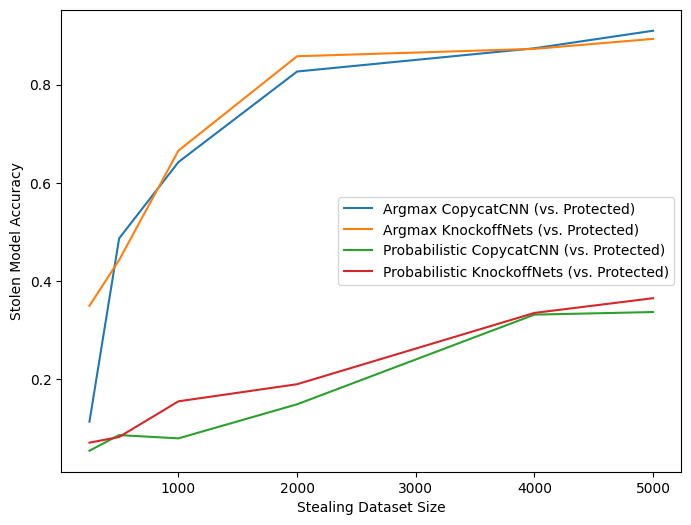

In [13]:
import pandas as pd
df_protected = pd.DataFrame(results_protected, columns=('Method Name', 'Stealing Dataset Size', 'Accuracy'))
fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlabel("Stealing Dataset Size")
ax.set_ylabel("Stolen Model Accuracy")
for name, group in df_protected.groupby("Method Name"):
    group.plot(1, 2, ax=ax, label=name)
plt.show()

In [14]:
df_combined = pd.concat([df, df_protected])
groupby = df_combined.groupby("Method Name")

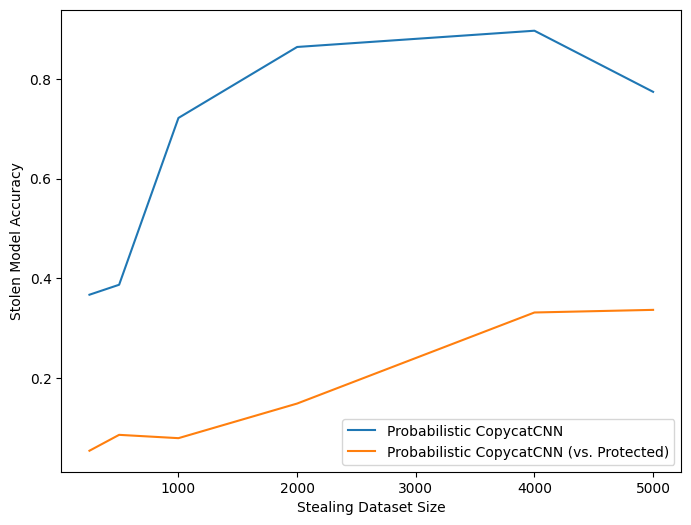

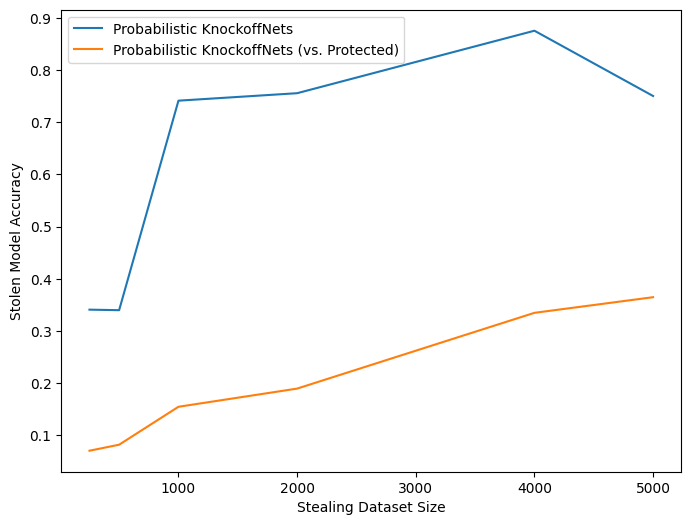

In [15]:
names = ["CopycatCNN", "KnockoffNets"]
for name in names:
    fig, ax = plt.subplots(figsize=(8,6))
    groupby.get_group("Probabilistic " + name).plot(1,2,ax=ax, label="Probabilistic " + name)
    groupby.get_group("Probabilistic " + name + " (vs. Protected)").plot(1,2,ax=ax, label="Probabilistic " + name + " (vs. Protected)")
    ax.set_xlabel("Stealing Dataset Size")
    ax.set_ylabel("Stolen Model Accuracy")
    fig.show()

#### Next Step: Using data augmentation can make the model stealing process much easier and faster, and can make the probabilistic attack much better.